<a href="https://colab.research.google.com/github/GustavFredrikson/Statistical-Machine-Learning/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt

import sklearn.model_selection as skl_ms
import sklearn.discriminant_analysis as skl_da
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [40]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

train.head()

,Number words female,Total words,Number of words lead,Difference in words lead and co-lead,Number of male actors,Year,Number of female actors,Number words male,Gross,Mean Age Male,Mean Age Female,Age Lead,Age Co-Lead,Lead
0,1512,6394,2251.0,343,2,1995,5,2631,142.0,51.500000,42.333333,46.0,65.0,Female
1,1524,8780,2020.0,1219,9,2001,4,5236,37.0,39.125000,29.333333,58.0,34.0,Male
2,155,4176,942.0,787,7,1968,1,3079,376.0,42.500000,37.000000,46.0,37.0,Male
3,1073,9855,3440.0,2623,12,2002,2,5342,19.0,35.222222,21.500000,33.0,23.0,Male
4,1317,7688,3835.0,3149,8,1988,4,2536,40.0,45.250000,45.000000,36.0,39.0,Male


# Firstly using LDA and QDA with train test split 80% training 20% testing

In [41]:
train_1, test_1 = skl_ms.train_test_split(train, train_size=0.8, random_state=1)

y_train = train_1["Lead"]
x_train = train_1.drop(columns=["Lead"])
x_test = test_1.drop(columns=["Lead"])
y_test = test_1["Lead"]

In [42]:
model = skl_da.LinearDiscriminantAnalysis()
preds = model.fit(x_train, y_train)
print(f"Using LDA: \n Accuracy on train data: \t {preds.score(x_train, y_train)}")
print(f" Accuracy on test data: \t {preds.score(x_test, y_test)} \n\n")

Using LDA: 
 Accuracy on train data: 	 0.8628158844765343
 Accuracy on test data: 	 0.8894230769230769 




In [43]:
model = skl_da.QuadraticDiscriminantAnalysis()
preds = model.fit(x_train, y_train)

print(f"Using QDA: \n Accuracy on train data: \t {preds.score(x_train, y_train)}")
print(f" Accuracy on test data: \t {preds.score(x_test, y_test)}")

Using QDA: 
 Accuracy on train data: 	 0.8844765342960289
 Accuracy on test data: 	 0.8509615384615384


# Implement using kfold 5 folds



Mean LDA on test data: 86.8%
Mean QDA on test data: 85.7%



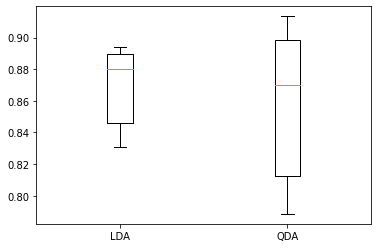

In [44]:
X = train.drop(columns=["Lead"])
y = train["Lead"]

kf = skl_ms.KFold(n_splits=5)

scores = {"LDA": [], "QDA": []}
for train_idx, test_idx in kf.split(train):
    x_train, x_val = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    scores["LDA"].append(skl_da.LinearDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))
    scores["QDA"].append(skl_da.QuadraticDiscriminantAnalysis().fit(
        x_train, y_train).score(x_val, y_val))

print(f"Mean LDA on test data: {round(statistics.mean(scores['LDA'])*100, 1)}%")
print(f"Mean QDA on test data: {round(statistics.mean(scores['QDA'])*100, 1)}%\n")

plt.boxplot([scores["LDA"], scores["QDA"]])
plt.xticks([1,2], ["LDA", "QDA"])
plt.show()

# Optimize Parameters

Mean LDA on test data: 86.8%
Mean QDA on test data: 85.7%



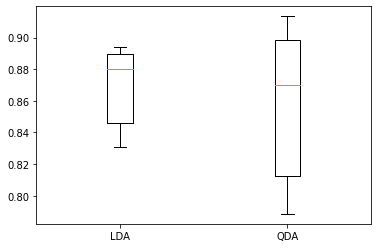

In [45]:
X = train.drop(columns=["Lead"])
y = train["Lead"]

kf = skl_ms.KFold(n_splits=5) # 2 for regular test/train split

solver = ["svd", "lsqr", "eigen"]
shrinkage = ["auto", None]
store_covariance = [True, False]
tol = [float(x) for x in np.linspace(start=1e-5, stop=1, num=20)]
random_grid = {
    'solver': solver,
    'shrinkage': shrinkage,
    'store_covariance': store_covariance,
    'tol': tol
}

rd_gridQDA = {
    'tol': tol
}

scores = {"LDA": [], "QDA": []}
for train_idx, test_idx in kf.split(train):
    x_train, x_val = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

    LDA = skl_da.LinearDiscriminantAnalysis()
    LDA_grid = GridSearchCV(estimator=LDA, param_grid=random_grid, cv=3, n_jobs=-1)
    LDA_grid.fit(x_train, y_train)
    scores["LDA"].append(LDA_grid.score(x_val, y_val))

    QDA = skl_da.QuadraticDiscriminantAnalysis()
    QDA_grid = GridSearchCV(estimator=QDA, param_grid=rd_gridQDA, cv=3, n_jobs=-1)
    QDA_grid.fit(x_train, y_train)
    scores["QDA"].append(QDA_grid.score(x_val, y_val))

print(f"Mean LDA on test data: {round(statistics.mean(scores['LDA'])*100, 1)}%")
print(f"Mean QDA on test data: {round(statistics.mean(scores['QDA'])*100, 1)}%\n")

plt.boxplot([scores["LDA"], scores["QDA"]])
plt.xticks([1,2], ["LDA", "QDA"])
plt.show()

Did not give better result...